In [2]:
import numpy as np
from numpy import linalg as la
from os import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import autograd
from math import *
%matplotlib inline

# Problem 1 - Exercise in $\mathbb{R}^3$

We are given the following optimization problem:

\begin{align}
&\underset{x}\min & & x_1 x_2 + x_2 x_3 \\
& \text{s.t.} & & x_1^2 + x_2^2 - 2 = 0 \\ 
& & & x_1^2 + x_3^2 - 2 = 0
\end{align}

Let $\mathbf{x} = \begin{pmatrix} x_1 \\ x_2 \\ x_3 \end{pmatrix} \in \mathbb{R}^3$. We are to minimize $f(\mathbf{x}) = x_1 x_2 + x_2 x_3$ subject to the constraint: $\mathbf{h}(\mathbf{x}) = \begin{pmatrix} h_1(\mathbf{x}) \\ h_2(\mathbf{x}) \end{pmatrix} = \begin{pmatrix} x_1^2 + x_2^2 - 2 \\ x_1^2 + x_3^2 - 2 \end{pmatrix} = \mathbf{0}$.

We form the Lagrangian of the above problem as follows:

$$\mathcal{L}(\mathbf{x}, \mathbf{\lambda}) = f(\mathbf{x}) + \lambda^\top \mathbf{h}(\mathbf{x}) = x_1 x_2 + x_2 x_3 + \lambda_1 (x_1^2 + x_2^2 - 2) + \lambda_2 (x_2^2 + x_3^2 - 2)$$

where $\mathbf{\lambda} = \begin{pmatrix} \lambda_1 \\ \lambda_2 \end{pmatrix} \in \mathbb{R^2}$. 

The first order optimality conditions are given by: $\begin{cases} \nabla_{\mathbf{x}} \mathcal{L}(\mathbf{x}, \mathbf{\lambda}) = 0 \\ \nabla_{\mathbf{\lambda}} \mathcal{L}(\mathbf{x}, \mathbf{\lambda}) = 0 \end{cases}$. Solving for the 2 gradients, we get: 

$\nabla_{\mathbf{x}} \mathcal{L}(\mathbf{x}, \mathbf{\lambda}) = \begin{pmatrix} x_2 \\ x_1 + x_3 \\ x_2 \end{pmatrix} + \lambda_1 \begin{pmatrix} 2x_1 \\ 2x_2 \\ 0 \end{pmatrix} + \lambda_2 \begin{pmatrix} 0 \\ 2x_2 \\ 2x_3\end{pmatrix} = \begin{pmatrix} x_2 + 2\lambda_1 x_1 \\ x_1 + x_3 + 2\lambda_1 x_2 + 2\lambda_2 x_2 \\ x_2 + 2\lambda_2 x_3 \end{pmatrix} = \mathbf{0}.$

$\nabla_{\mathbf{\lambda}} \mathcal{L}(\mathbf{x}, \mathbf{\lambda}) = \begin{pmatrix} x_1^2 + x_2^2 - 2 \\ x_2^2 + x_3^2 - 2 \end{pmatrix} = \mathbf{0}$.

This yields the following system of non-linear equations to be solved:

$\begin{cases} x_2 &+ &2\lambda_1 x_1 &&&& & = 0 \\ x_1& + &x_3 &+ &2\lambda_1 x_2 &+& 2\lambda_2 x_2 &= 0 \\ x_2& +& 2\lambda_2 x_3&&&& &= 0\\ x_1^2 &+& x_2^2 &- &2&& &= 0\\ x_2^2& +& x_3^2 &-& 2&&& = 0 \end{cases}$

## Defining the system and the corresponding gradients

For computational reasons and code cleanness, we consider $\mathbf{x} = \begin{pmatrix} x_1 \\ x_2 \\ x_3 \\ \lambda_1 \\ \lambda_2 \end{pmatrix}$.

In [3]:
import sympy as sp
# symbic function and its jacobian
x1 = sp.Symbol('x1')
x2 = sp.Symbol('x2')
x3 = sp.Symbol('x3')
lamda1 = sp.Symbol('lamda1')
lamda2 = sp.Symbol('lamda2')
x = np.array([x1, x2,x3,lamda1,lamda2])
g_Lx1=x[1]-2*lamda1*x[0]-2*lamda2*x[0]
g_Lx2=x[0]+x[2]-2*lamda1*x[1]
g_Lx3=x[1]-2*lamda2*x[2]
g_L_lam1=x1**2 + x2**2 - 2
g_L_lam2= x1**2 + x3**2 - 2

F = sp.Matrix([g_Lx1,g_Lx2,g_Lx3,g_L_lam1,g_L_lam2])
#F = sp.Matrix([f_symb,g_symb1,g_symb2])
J=F.jacobian(x)
#J=sp.derive_by_array(F,x)
#Eq = np.transpose(np.transpose(lam)*J)
#Eq = np.transpose(lam)*J

F_true=sp.lambdify([x], F, np)
J_true=sp.lambdify([x], J, np)


In [4]:
J
#Full_Eq

Matrix([
[-2*lamda1 - 2*lamda2,         1,         0, -2*x1, -2*x1],
[                   1, -2*lamda1,         1, -2*x2,     0],
[                   0,         1, -2*lamda2,     0, -2*x3],
[                2*x1,      2*x2,         0,     0,     0],
[                2*x1,         0,      2*x3,     0,     0]])

In [5]:
a=np.array([1,1,0.5,0.1,0.2])
np.transpose(J_true(a)).shape

(5, 5)

Globalized newton method

In [6]:
def merit_func(f,x):
    return .5*np.transpose(f(x))@f(x).reshape(-1)

def backtrack_linesearch(F_true,merit_func, gk, pk, xk, alpha = 0.1, beta = 0.8):
    t = 1
    while ( merit_func(F_true,xk + t*pk)[0] >= merit_func(F_true,xk)[0] + gk @ pk*alpha * t  ):
        t *= beta
    return t
    

In [7]:

a=np.array([1,1,1,1,1])
history=a
while(la.norm(F_true(a)) > 1e-6):
    print(la.norm(F_true(a)))
    #using svd
    inv=la.pinv(np.transpose(J_true(a))@J_true(a).reshape(5,5),rcond=1e-3)
    p=-inv@np.transpose(J_true(a))@F_true(a).reshape(-1)
    t = backtrack_linesearch(F_true,merit_func,np.transpose(J_true(a))@F_true(a).reshape(-1), p, a)
    a=a+t*p
    history = np.vstack( (history, a) )

3.1622776601683795
0.5796011559684817
0.08432770501379501
0.0008563365753152141


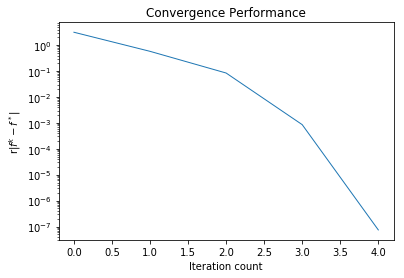

In [8]:
nsteps = history.shape[0]
fhist = np.zeros(nsteps)
for i in range(nsteps):
    fhist[i] = la.norm(F_true(history[i]))
plt.figure()

plt.semilogy(np.arange(0, nsteps), fhist, linewidth=1)
plt.title('Convergence Performance')
plt.xlabel('Iteration count')
plt.ylabel('r$|f^k - f^*|$')
plt.show()

In [424]:
history[-1]

array([0.5411961 , 1.30656297, 1.30656297, 0.70710676, 0.50000002])

# Problem 2 - Significance of the Lagrange Multipliers


Consider the optimization problem:

\begin{equation}
\begin{aligned}
& \underset{x}\min
& & f(x) \\
& \text{s.t.} & &  h_i(x) = 0  \quad i = 1, \ldots, p\\
\end{aligned}
\end{equation}


We assume this problem has an optimal solution $x^*$. At $x^*$, we have $h_i(x^*) = 0 \; \forall i = 1, \ldots, p$. Assume, the $i^{th}$ constraint is varied by $\epsilon$. Using Taylor's expansion of $h_i(\cdot)$ at $x^*$:

\begin{align}
h_i(x^* + \Delta x) & = h_i(x^*) + \nabla h_i(x^*)^\top \Delta x + \ldots \\ 
& = 0 + \nabla h_i(x^*)^\top \Delta x + \ldots \\ 
& = \epsilon \\ 
\end{align}

We thus have $\nabla h_i(x^*)^\top \Delta x = \epsilon$. We now examine the value of $f(\cdot)$ a $\Delta x$ step from $x^*$. Using Taylor's expansion:

\begin{align}
f(x^* + \Delta x) & = f(x^*) + \nabla f(x^*)^\top \Delta x + \ldots \\ 
\end{align}

We find that, up to an error of $o\left(\lVert \Delta x \lVert^2\right)$:

\begin{align}
\Delta f & = f(x^* + \Delta x) - f(x^*) & \\
& = \nabla f(x^*)^\top \Delta x & \\
& = \left(- \lambda^{*^\top} \nabla \mathbf{h} (x^*)\right) ^ \top \Delta x & \\ 
& = - \lambda_i^* \nabla h_i(x^*)^\top \Delta x & \left(\nabla h_j^* \bot \Delta x \quad \forall \, j \neq i\right) \\ 
& = -\lambda_i^* \, \epsilon
\end{align}

For infinitesimal change, we get $\frac{df^*}{d\epsilon} = -\lambda_i^*$. This means that if the $i^{th}$ constraint changes by $\epsilon$, the objective function value will change by $-\lambda_i^*$, i.e. the Lagrangian multipliers can be thought of as the sensitivities of the objective function relative to the constraints.

# Problem 3 - Nonnegativity of the Lagrange Multipliers

Let the optimization problem be defined as follows:

\begin{equation}
\begin{aligned}
& \underset{x} \min & & f(x) \\
& \text{s.t.} & & h_i(x) = 0 \quad i = 1, \ldots, p \\
& & & g_i(x) \leq 0 \quad i = 1, \dots, m
\end{aligned}
\end{equation}

where $x\in \mathbb{R}^n$, and $f, h_i, g_j: \mathbb{R}^n \rightarrow \mathbb{R} \quad \forall \,i, \,j$.

We define the Lagrangian of the equation as:

$$
\mathcal{L}(x; \mu, \lambda) = f(x) + \mu^\top \mathbf{h} (x) + \lambda^\top \mathbf{g}(x)
$$
where $\mu = \left[ \mu_1, \ldots, \mu_p \right]^\top \in \mathbb{R}^p$ and $\lambda = \left[ \lambda_1, \ldots, \lambda_m \right]^\top \in \mathbb{R}_+^m$. In this problem, we will justify the range of the Lagrangian multipliers.

In general, for a given optimization problem, there are 2 types of relaxations:
- 1\. Removing one or multiple constraints (assuming the removed constraints are active at the optimal point). This makes the feasible region bigger, and hence introduces the possibility of having a new minimum.
- 2\. Let $\tilde{f}: \mathbb{R}^n \rightarrow \mathbb{R}$ be such that $\tilde{f}(x) \leq f(x) \; \forall x$. Solving the optimization problem with the new objective $\tilde{f}$ results in an optimal point $\tilde{x}^* \leq x^*$.

The Lagrangian equivalent incorporates these 2 relaxations, by removing all constraints, and adding the constraints to the objective function in a way that the new objective function is a relaxed version of the old one. To see this, consider the following. 

At the optimal point, $\mathbf{h}(x^*) = \mathbf{0}$, this means that $f(x^*) + \mu^\top \mathbf{h}(x^*) = f(x^*) + 0 = f(x^*)$. This means that no matter the value of $\mu$, the optimal value is not changed, and thus $mu$ can take on any real value. 
Similarly, at the optimal point, we have $\mathbf{g}(x^*) \leq \mathbf{0}$. The new objective value at the optimal point is thus $f(x^*) + \mu^\top \mathbf{h}(x^*) + \lambda^\top \mathbf{g}(x^*) = f(x^*) + 0 + \lambda^\top \mathbf{g}(x^*)$. Since $\mathbf{g}(x^*) \leq \mathbf{0}$, the only way $\tilde{f}(x^*) \leq f(x^*)$ is by forcing $\lambda \geq 0$.

To see it differently, if $\lambda \leq 0$, we will have $f(x^*) + \lambda^\top \mathbf{g}(x^*) \geq f(x^*)$. Solving the new problem will thus result in an optimal value larger than the original optimal value, and thus failing to get the optimal value.

To show this, consider the following optimization problem:

\begin{equation}
\begin{aligned}
& \underset{x}\min & & x(x-1)(x+2)^2 \\
& \text{s.t.} & & 0.25(x-1)^2 - 2 \leq 0
\end{aligned}
\end{equation}

This can be seen as follows.

# Problem 4 - Necessary but not sufficient conditions


Consider the following optimization problem:

\begin{equation}
\begin{aligned}
& \underset{x} \min & & x_1 - x_2 \\
& \text{s.t.} & & x_1 x_2 + 4 = 0
\end{aligned}
\end{equation}

Consider also the 2 points $a = [-2, 2]^\top$ and $b = [2, -2]^\top$. The Lagrangian is given by:

$$\mathcal{L}(x; \mu) = x_1 - x_2 + \mu (x_1 x_2 + 4)$$

The first order optimality conditions are:
$$\nabla_x \mathcal{L} = \begin{pmatrix} 1 + \mu x_2 \\ -1 + \mu x_1
\end{pmatrix} = 0$$

$$\nabla_\mu \mathcal{L} = x_1 x_2 + 4 = 0$$

For point $a = [-2, 2]^\top$ , we have:

$$\nabla_x \mathcal{L}(a; \mu) = \begin{pmatrix} 1 + 2\mu \\ -1 - 2\mu\end{pmatrix} = 0$$

giving $\mu = -\frac{1}{2}$.

$$\nabla_\mu \mathcal{L}(a; \mu) = -2 \times 2 + 4 = 0$$

Similarly, for point $b = [2, -2]^\top$ , we have:

$$\nabla_x \mathcal{L}(b; \mu) = \begin{pmatrix} 1 - 2\mu \\ -1 + 2\mu\end{pmatrix} = 0$$

giving $\mu = \frac{1}{2}$.

$$\nabla_\mu \mathcal{L} (b; \mu) = 2 \times (-2) + 4 = 0$$

This shows both $a$ and $b$ satisfy the first order optimality conditions. However neither point is a solution. To see this, let $x_1 = \frac{-4}{x_2}$. By letting $x_2 \rightarrow 0^+$, we will have $x_1 \rightarrow - \infty$. This means the objective function will tend to $-\infty$, and the problem is unbounded, admitting no real optimal point.

This shows that the first order optimality conditions are necessary for a point to be a feasible solution, however, they are not sufficient so the points that satisfy them be optimal.

# Problem 5 - Healthy Snack

A health conscious buyer needs at least $6$ ounces of chocolate, $10$ ounces of sugar and $8$ ounces of cream cheese. We have 2 products: Brownies ($x_1$) and Cheesecakes ($x_2$), costing $50$ and $80$ cents respectively. The following table shows the contents of each product along with the cost:

\begin{array}{|l|c|c|c|c|}
\hline & Chocolate & Sugar  & Cream \; Cheese & Cost \\ 
\hline Brownie \; (x_1)& 3 & 2 & 2 & 50 \\ \hline
Cheesecake \; (x_2) & 0 & 4 & 5 & 80 \\ \hline
\end{array}

We can formulate the following optimization problem:

\begin{equation}
\begin{aligned}
& \underset{x} \min & & 50x_1 + 80 x_2 \\ 
& \text{s.t.} & & 3x_1 \geq 6 \\
& & & 2x_1 + 4x_2 \geq 10 \\ 
& & & 2x_1 + 5x_2 \geq 8
\end{aligned}
\end{equation}

Let $c = \begin{pmatrix} 50 \\ 80 \end{pmatrix}$, $\begin{pmatrix} x_1 \\ x_2 \end{pmatrix} \in \mathbb{R}^+$, $A = \begin{pmatrix} -3 & 0 \\ -2 & -4 \\ -2 & -5 \end{pmatrix}$ and $b = \begin{pmatrix} -6 \\ -10 \\ -8 \end{pmatrix}$.

We can then reformulate the problem as follows (form required by $\textbf{ linprog}$):

\begin{equation}
\begin{aligned}
& \underset{x} \min & & c^\top x \\ 
& \text{s.t.} & & Ax \leq b
\end{aligned}
\end{equation}

In [9]:
from scipy.optimize import linprog

In [10]:
A = np.array([[-3, 0], [-2, -4], [-2, -5]])
b = np.array([-6, -10, -8])
c = np.array([50, 80])

In [11]:
sol = linprog(c, A_ub = A, b_ub = b)
print(sol)

     con: array([], dtype=float64)
     fun: 220.0
 message: 'Optimization terminated successfully.'
     nit: 2
   slack: array([0. , 0. , 3.5])
  status: 0
 success: True
       x: array([2. , 1.5])


The optimal value is $220$ cents when buying $2$ brownies and $1.5$ cheesecake.

We can write the Lagrangian as: 

\begin{align}
\mathcal{L}(\mathbf{x}, \lambda)&  = f(\mathbf{x}) + \lambda^\top \mathbf{g}(\mathbf{x}) \\
& = \mathbf{c}^\top \mathbf{x} + \lambda^\top (A \mathbf{x} - \mathbf{b}) \\ 
& = 50x_1 + 80x_2 + \lambda_1 (-3x_1 + 6) + \lambda_2 (-2x_1 -4x_2 + 10) + \lambda_3 (-2x_1 -5x_2 + 8)
\end{align} 

The optimality conditions are:

\begin{align}
\nabla_{\mathbf{x}} \mathcal{L}(\mathbf{x}, \lambda) & = \nabla_{\mathbf{x}}f(\mathbf{x}) + \lambda^\top \nabla_{\mathbf{x}} \mathbf{g}(\mathbf{x}) \\ 
& = \begin{pmatrix} 50 \\ 80 \end{pmatrix} + \lambda_1 \begin{pmatrix}-3 \\ 0 \end{pmatrix} + \lambda_2 \begin{pmatrix}-2 \\ -4 \end{pmatrix} + \lambda_3 \begin{pmatrix}-2 \\ -5 \end{pmatrix} \\
& = \begin{pmatrix}50 - 3\lambda_1 - 2\lambda_2 - 2\lambda_3 \\ 80 - 4\lambda_2 - 5\lambda_3\end{pmatrix} = \mathbf{0} \\ \\
\lambda \circ (A\mathbf{x} - \mathbf{b})& = \begin{pmatrix} \lambda_1 (-3x_1 + 6) \\ \lambda_2 (-2x_1 -4x_2 + 10) \\ \lambda_3 (-2x_1 -5x_2 + 8) \end{pmatrix} \\ & = \begin{pmatrix} \lambda_1 \cdot 0 \\ \lambda_2 \cdot 0 \\ \lambda_3 \cdot -3.5 \end{pmatrix} = \mathbf{0} & \text{(complementary slackness)}
\end{align}

This gives us $\lambda_3 = 0$, and the system: $\begin{cases}3\lambda_1 & + & 2\lambda_2 & = 50 \\ & & 4\lambda_2 & = 80 \end{cases}$ which yields $\lambda_1 = \frac{10}{3}$ and $\lambda_2 = 20$.

This means that the $2^{nd}$ constraint (corresponding to sugar quantity) is the one affecting the price the most, and changing its value will affect the price the most. The $1^{st}$ constraint has some effect but much smaller than the $2^{nd}$, and the last constraint has practically no effect, since satisfying the above 2 constraints will make it satisfied automatically, and thus changing the requirement of cream cheese a bit won't affect the total price.

The optimization problem in canonical form is:

\begin{equation}
\begin{aligned}
& \underset{x} \min & & 50x_1 + 80 x_2 \\ 
& \text{s.t.} & & 3x_1 - 6 \geq 0 \\
& & & 2x_1 + 4x_2 - 10\geq 0 \\ 
& & & 2x_1 + 5x_2 - 8 \geq 0
\end{aligned}
\end{equation}

